In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import time
import dill
import sys
import os

sys.path.insert(0, "../../utils/")
import utils as ut
import fancyplots as fp
from regr_models import neuralNewtorkRegression, plotLayersCrossVal

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Input options

In [3]:
# fixed training options 
# (high batch_size so that the training is fast)
epochs           = 100
validation_split = 0.1
batch_size       = 128
verbose_training = False
learning_rate    = 0.001
dict_name        = 'NN_crossvalidation_GstLAL.dict'

save_at_every_step = True

In [4]:
# start with a loop on architectures
hlayers_sizes_list = [(10,), (50,), (100,), (150,), (200,), (300,), \
                      (100,100), (200,200), (300,300) ];

scaler_types       = ['minmax']  # standard, minmax, mixed
hidden_activations = ['relu']
out_activations    = ['linear'] # sigmoid, linear, linear_cut, linear_cut_T3, linear_cut_lb, linear_cut_mod
loss_functions     = ['mse']

"""
hlayers_sizes_list = []
for i in range(25, 301, 25):
    for j in range(0, 301, 25):
        if j>0:
            hlayers_size = (i,j)
        else:
            hlayers_size = (i,)
        #print(hlayers_size)
        hlayers_sizes_list.append(hlayers_size)
""";

## Load dataset

In [5]:
#------------------------------------------------------------------
# v0c0
#------------------------------------------------------------------
#features_names = ['m1', 'm2', 's1x', 's1y', 's1z', 's2x', 's2y', 's2z',\
#                  'theta', 'q', 'Mc'];
#regr_data_dir  = '../../datasets/NewRealistic/'
#out_data_dir   = '../../datasets/NN_tf_results/'
#
#data_paths = {}
#data_paths['xtrain'] = regr_data_dir+'v0c0train_x.csv'
#data_paths['ytrain'] = regr_data_dir+'v0c0train_y.csv'
#data_paths['xtest']  = regr_data_dir+'v0c0test_x.csv'
#data_paths['ytest']  = regr_data_dir+'v0c0test_y.csv'

#------------------------------------------------------------------
# GstLAL
#------------------------------------------------------------------
regr_data_dirs = ["../../datasets/GSTLAL_EarlyWarning_Dataset/Dataset/",
                  "..\\GSTLAL_EarlyWarning_Dataset\\Dataset\\"]
for path in regr_data_dirs:
    if os.path.isdir(path):
        regr_data_dir = path  
        print(regr_data_dir)

# load data
features_names       = ['m1', 'm2']
data_paths           = {}
data_paths['xtrain'] = regr_data_dir+'train_recover.csv'
data_paths['ytrain'] = regr_data_dir+'train_inject.csv'
data_paths['xtest']  = regr_data_dir+'test_recover.csv'
data_paths['ytest']  = regr_data_dir+'test_inject.csv'

rdl_out = ut.regressionDatasetLoader(data_paths, features_names,
                       remove_some_mass=False,
                       scaler_type=None)
xtrain_notnormalized = rdl_out['xtrain']
ytrain_notnormalized = rdl_out['ytrain']
xtest_notnormalized  = rdl_out['xtest']
ytest_notnormalized  = rdl_out['ytest']
labels               = rdl_out['labels']

../../datasets/GSTLAL_EarlyWarning_Dataset/Dataset/


## Define some functions and load the dictionary

In [6]:
def param2Key(epochs, batch_size, learning_rate, scaler_type, hidden_activation,\
              out_activation, loss_function, hlayers_sizes):
    key  = str(epochs)+'-'+str(batch_size)+'-'+'alpha'+str(learning_rate)+'-'
    key += scaler_type + '-' + hidden_activation + '-' + out_activation + '-'
    key += loss_function + '-'
    Nlayers = len(hlayers_sizes)
    key += str(Nlayers) + 'layers:'
    for i in range(0, Nlayers):
        key += str(hlayers_sizes[i])
        if i<Nlayers-1:
            key += '+'
    return key

def saveDict(mydict, fname, verbose=True):
    out_dict_dir = './'
    dict_name = out_dict_dir+fname
    dill.dump(mydict, open(dict_name, 'wb'))
    if verbose:
        print(dict_name, 'saved') 

def loadDict(fname, verbose=True):
    out_dict_dir = './'
    dict_name = out_dict_dir+fname
    if os.path.exists(dict_name):
        loaded_dict = dill.load(open(dict_name, 'rb'))
        if verbose:
            print(dict_name, 'loaded')
    else:
        loaded_dict = {}
        if verbose:
            print(dict_name, 'not found, returning empty dictionary')
    return loaded_dict    

In [7]:
models_dict = loadDict(dict_name)

./NN_crossvalidation_GstLAL.dict loaded


## Cross validation 

In [8]:
# create all the possible combinations
combinations = []
for hlayers_sizes in hlayers_sizes_list:
    for out_activation in out_activations:
        for hidden_activation in hidden_activations:
            for scaler_type in scaler_types:
                for loss_function in loss_functions:
                    combination = lambda:0
                    combination.out_activation    = out_activation
                    combination.hidden_activation = hidden_activation
                    combination.scaler_type       = scaler_type
                    combination.hlayers_sizes     = hlayers_sizes
                    combination.loss_function     = loss_function
                    combinations.append(combination)

In [9]:
asterisks = '*'*80

for combination in combinations:
    hlayers_sizes     = combination.hlayers_sizes
    out_activation    = combination.out_activation
    hidden_activation = combination.hidden_activation
    scaler_type       = combination.scaler_type
    loss_function     = combination.loss_function
    
    key = param2Key(epochs, batch_size, learning_rate, scaler_type, \
                    hidden_activation, out_activation, loss_function, hlayers_sizes)
    
    dict_keys = models_dict.keys()
    
    if key in dict_keys:
        print('key ', key, ' already exists!', sep='')
    else:
        t0 = time.perf_counter()
        outNN = neuralNewtorkRegression(xtrain_notnormalized, ytrain_notnormalized,
                    scaler_type       = scaler_type,                   
                    epochs            = epochs, 
                    batch_size        = batch_size, 
                    learning_rate     = learning_rate,          
                    validation_split  = validation_split,   
                    verbose           = verbose_training,             
                    hlayers_sizes     = hlayers_sizes,          
                    out_activation    = out_activation,        
                    hidden_activation = hidden_activation,
                    loss_function     = loss_function)
        train_time = time.perf_counter()-t0

        model    = outNN["model"]
        history  = outNN["history"]
        Npars    = outNN["Npars"]
        scaler_x = outNN["scaler_x"]
        scaler_y = outNN["scaler_y"]

        xtest = scaler_x.transform(xtest_notnormalized)
        ytest = scaler_y.transform(ytest_notnormalized)
        
        ypredicted = model.predict(xtest)
        
        metrics_dict = ut.evalutationMetricsDict(xtest,ytest,model)

        # show plots and print info
        print(asterisks)
        print(key)
        print('Layers: ', end='')
        for layer in hlayers_sizes:
            print(layer,end=' ')
        print('\ntrainable pramaters: ', Npars, \
              '\ntrain time: {:.3f}'.format(train_time), '\n', \
              asterisks, sep='', end='\n')
        ut.printMetrics(metrics_dict)
        
        #fp.regrPredictionPlots(ytest, ypredicted, labels, scaler=scaler_y)
        fp.plotHistory(history)

        # save info/score in the dictionary
        models_dict[key]                     = lambda:0
        models_dict[key].Npars               = Npars
        models_dict[key].metrics             = metrics_dict
        models_dict[key].train_time          = train_time
        models_dict[key].Nlayers             = len(hlayers_sizes)
        models_dict[key].hlayers_sizes       = hlayers_sizes
        models_dict[key].epochs              = epochs
        models_dict[key].batch_size          = batch_size
        models_dict[key].scaler_type         = scaler_type
        models_dict[key].out_activation      = out_activation
        models_dict[key].hidden_activation   = hidden_activation
        models_dict[key].loss_function       = loss_function
        models_dict[key].learning_rate       = learning_rate
        models_dict[key].prediction          = ypredicted
        models_dict[key].prediction_rescaled = scaler_y.inverse_transform(ypredicted)

        # we are not saving the model 
        # (we cannot pickle/dill it! we need to use keras-stuff)
        #models_dict[key].model      = model
        #models_dict[key].scaler_x   = scaler_x
        #models_dict[key].scaler_y   = scaler_y
        #models_dict[key].history    = history

        del outNN
        
        if save_at_every_step:
            saveDict(models_dict,dict_name)

if not save_at_every_step:
    saveDict(models_dict,dict_name)

key 100-128-alpha0.001-minmax-relu-linear-mse-1layers:10 already exists!
key 100-128-alpha0.001-minmax-relu-linear-mse-1layers:50 already exists!
key 100-128-alpha0.001-minmax-relu-linear-mse-1layers:100 already exists!
key 100-128-alpha0.001-minmax-relu-linear-mse-1layers:150 already exists!
key 100-128-alpha0.001-minmax-relu-linear-mse-1layers:200 already exists!
key 100-128-alpha0.001-minmax-relu-linear-mse-1layers:300 already exists!
key 100-128-alpha0.001-minmax-relu-linear-mse-2layers:100+100 already exists!
key 100-128-alpha0.001-minmax-relu-linear-mse-2layers:200+200 already exists!
key 100-128-alpha0.001-minmax-relu-linear-mse-2layers:300+300 already exists!


## Plots 

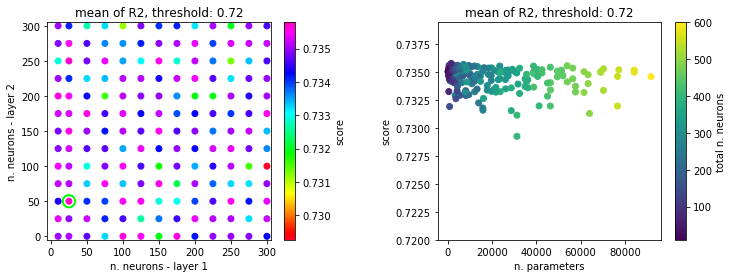

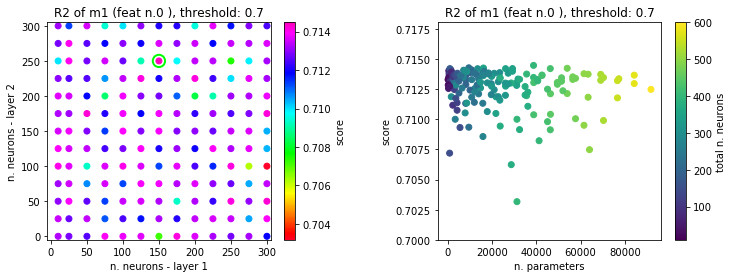

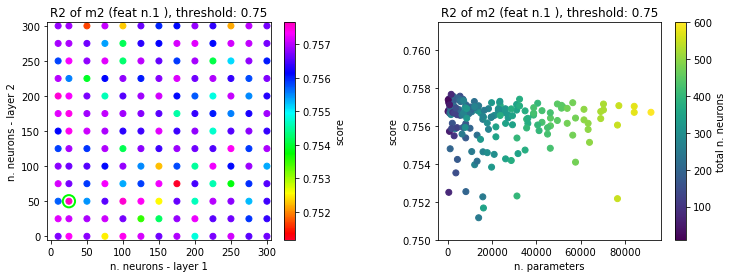

In [10]:
#thresholds             = [0.98, 0.98, \
#                          0.92, 0.92, 0.92, 0.92, 0.92, 0.92, \
#                          0.8, 0.98, 0.98]
thresholds             = [0.7, 0.75]
Npars_lim              = 1e+6
hidden_activation_plot = 'relu'
out_activation_plot    = 'linear'
loss_function          = 'mse'
scaler_type_plot       = 'minmax'
batch_size_plot        = 128
epochs_plot            = 100

plotLayersCrossVal(models_dict, 
      threshold         = 0.72, 
      Npars_lim         = Npars_lim,
      hidden_activation = hidden_activation_plot,
      out_activation    = out_activation_plot,
      loss_function     = loss_function,
      scaler_type       = scaler_type_plot,
      batch_size        = batch_size_plot,
      epochs            = epochs_plot,
      metrics_idx       = -1,
      labels            = labels)
                          
for i in range(0, len(labels)):
    plotLayersCrossVal(models_dict,
        threshold         = thresholds[i],
        Npars_lim         = Npars_lim,
        hidden_activation = hidden_activation_plot,
        out_activation    = out_activation_plot,
        loss_function     = loss_function,
        scaler_type       = scaler_type_plot,
        batch_size        = batch_size_plot,
        epochs            = epochs_plot,
        metrics_idx       = i,
        labels            = labels)